<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/Quantum_Machine_Learning/variational_classifier_qng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a modified notebook by Maria Schuld adopted from https://blog-assets.cloud.pennylane.ai/demos/tutorial_variational_classifier/main/demo.ipynb

In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
!pip install pennylane

# Variational classifier {#variational_classifier}

::: meta
:property=\"og:description\": Using PennyLane to implement quantum
circuits that can be trained from labelled data to classify new data
samples. :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets/classifier_output_59_0.png>
:::

::: related
tutorial_data_reuploading_classifier Data-reuploading classifier
tutorial_multiclass_classification Multiclass margin classifier
ensemble_multi_qpu Ensemble classification with Rigetti and Qiskit
devices
:::

In this tutorial, we show how to use PennyLane to implement variational
quantum classifiers - quantum circuits that can be trained from labelled
data to classify new data samples. The two examples used are inspired by
two of the first papers that proposed variational circuits as supervised
machine learning models: [Farhi and Neven
(2018)](https://arxiv.org/abs/1802.06002) as well as [Schuld et al.
(2018)](https://arxiv.org/abs/1804.00633).


More precisely, the first example shows that a variational circuit can
be optimized to emulate the parity function

$$\begin{aligned}
f: x \in \{0,1\}^{\otimes n} \rightarrow y =
\begin{cases} 1 \text{  if uneven number of 1's in } x \\ 0
\text{ else}. \end{cases}
\end{aligned}$$

It demonstrates how to encode binary inputs into the initial state of
the variational circuit, which is simply a computational basis state
(*basis encoding*).

The second example shows how to encode real vectors as amplitude vectors
into quantum states (*amplitude encoding*) and how to train a
variational circuit to recognize the first two classes of flowers in the
Iris dataset.

# 1. Fitting the parity function

## Imports

We start by importing PennyLane, the PennyLane-provided version of
NumPy, and an optimizer.


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import QNGOptimizer, MomentumQNGOptimizer

# Quantum and classical nodes

We then create a quantum device that will run our circuits.


In [ ]:
dev = qml.device("default.qubit")

Variational classifiers usually define a "layer" or "block", which is an
elementary circuit architecture that gets repeated to build the full
variational circuit.

Our circuit layer will use four qubits, or wires, and consists of an
arbitrary rotation on every qubit, as well as a ring of CNOTs that
entangles each qubit with its neighbour. Borrowing from machine
learning, we call the parameters of the layer `weights`.


In [ ]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

We also need a way to encode data inputs $x$ into the circuit, so that
the measured output depends on the inputs. In this first example, the
inputs are bitstrings, which we encode into the state of the qubits. The
quantum state $\psi$ after state preparation is a computational basis
state that has 1s where $x$ has 1s, for example

$$x = 0101 \rightarrow |\psi \rangle = |0101 \rangle .$$

The `~pennylane.BasisState`{.interpreted-text role="class"} function
provided by PennyLane is made to do just this. It expects `x` to be a
list of zeros and ones, i.e. `[0,1,0,1]`.


In [ ]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

Now we define the variational quantum circuit as this state preparation
routine, followed by a repetition of the layer structure.


In [ ]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

If we want to add a "classical" bias parameter, the variational quantum
classifier also needs some post-processing. We define the full model as
a sum of the output of the quantum circuit, plus the trainable bias.


In [ ]:
def variational_classifier(weights, x):
    return circuit(weights, x)

# Cost

In supervised learning, the cost function is usually the sum of a loss
function and a regularizer. We restrict ourselves to the standard square
loss that measures the distance between target labels and model
predictions.


In [ ]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

To monitor how many inputs the current classifier predicted correctly,
we also define the accuracy, or the proportion of predictions that agree
with a set of target labels.


In [ ]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

For learning tasks, the cost depends on the data - here the features and
labels considered in the iteration of the optimization routine.


In [ ]:
def cost(weights, X, Y):
    predictions = [variational_classifier(weights, x) for x in X]
    return square_loss(Y, predictions)

# Optimization

Let's now load and preprocess some data.

::: note
::: title
Note
:::

The parity dataset\'s
`<a href="https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/parity_train.txt"
download=parity.txt target="_blank">train</a>`{.interpreted-text
role="html"} and
`<a href="https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/parity_test.txt"
download=parity.txt target="_blank">test</a>`{.interpreted-text
role="html"} sets can be downloaded and should be placed in the
subfolder `variational_classifier/data`.
:::


In [ ]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


We initialize the variables randomly (but fix a seed for
reproducibility). Remember that one of the variables is used as a bias,
while the rest is fed into the gates of the variational circuit.


In [ ]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)

print("Weights:", weights_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]


Next we create an optimizer instance and choose a batch size...


In [ ]:
opt = MomentumQNGOptimizer(0.01)
batch_size = 5

...and run the optimizer to train our model. We track the accuracy - the
share of correctly classified data samples. For this we compute the
outputs of the variational classifier and turn them into predictions in
$\{-1,1\}$ by taking the sign of the output.


In [ ]:
weights = weights_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    cost_fn = lambda w: cost(w, X_batch, Y_batch)
    metric_fn = lambda w: np.sum([qml.metric_tensor(circuit, approx="block-diag")(w, sample) for sample in X_batch], axis=0)/batch_size #we average the metric tensor over the batch

    weights, loss = opt.step_and_cost(cost_fn, weights, metric_tensor_fn=metric_fn)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, x)) for x in X]

    current_cost = cost(weights, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 1.9992627 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9992628 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9990086 | Accuracy: 0.5000000
Iter:    4 | Cost: 1.9987479 | Accuracy: 0.5000000
Iter:    5 | Cost: 1.9984874 | Accuracy: 0.5000000
Iter:    6 | Cost: 1.9976717 | Accuracy: 0.5000000
Iter:    7 | Cost: 1.9967888 | Accuracy: 0.5000000
Iter:    8 | Cost: 1.9958745 | Accuracy: 0.5000000
Iter:    9 | Cost: 1.9949560 | Accuracy: 0.5000000
Iter:   10 | Cost: 1.9921830 | Accuracy: 0.5000000
Iter:   11 | Cost: 1.9891817 | Accuracy: 0.5000000
Iter:   12 | Cost: 1.9819324 | Accuracy: 0.5000000
Iter:   13 | Cost: 1.9666673 | Accuracy: 0.5000000
Iter:   14 | Cost: 1.9359399 | Accuracy: 0.5000000
Iter:   15 | Cost: 1.9011083 | Accuracy: 0.5000000
Iter:   16 | Cost: 1.8307568 | Accuracy: 0.5000000
Iter:   17 | Cost: 1.7045775 | Accuracy: 0.5000000
Iter:   18 | Cost: 1.5109876 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.2769067 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1267484 | 

As we can see, the variational classifier learned to classify all bit
strings from the training set correctly.

But unlike optimization, in machine learning the goal is to generalize
from limited data to *unseen* examples. Even if the variational quantum
circuit was perfectly optimized with respect to the cost, it might not
generalize, a phenomenon known as *overfitting*. The art of (quantum)
machine learning is to create models and learning procedures that tend
to find \"good\" minima, or those that lead to models which generalize
well.

With this in mind, let\'s look at a test set of examples we have not
used during training:


In [ ]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


The quantum circuit has also learnt to predict all unseen examples
perfectly well! This is actually remarkable, since the encoding strategy
creates quantum states from the data that have zero overlap \-- and
hence the states created from the test set have no overlap with the
states created from the training set. There are many functional
relations the variational circuit could learn from this kind of
representation, but the classifier chooses to label bit strings
according to our ground truth, the parity function.

Let\'s look at the second example, in which we use another encoding
strategy.

# 2. Iris classification

We now move on to classifying data points from the Iris dataset, which
are no longer simple bitstrings but represented as real-valued vectors.
The vectors are 2-dimensional, but we will add some \"latent
dimensions\" and therefore encode inputs into 2 qubits.

## Quantum and classical nodes

State preparation is not as simple as when we represent a bitstring with
a basis state. Every input x has to be translated into a set of angles
which can get fed into a small routine for state preparation. To
simplify things a bit, we will work with data from the positive
subspace, so that we can ignore signs (which would require another
cascade of rotations around the Z-axis).

The circuit is coded according to the scheme in [Möttönen, et al.
(2004)](https://arxiv.org/abs/quant-ph/0407010), or---as presented for
positive vectors only---in [Schuld and Petruccione
(2018)](https://link.springer.com/book/10.1007/978-3-319-96424-9). We
also decomposed controlled Y-axis rotations into more basic gates,
following [Nielsen and Chuang
(2010)](http://www.michaelnielsen.org/qcqi/).


In [ ]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Let's test if this routine actually works.


In [ ]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


The method computed the correct angles to prepare the desired state!

> ::: note
> ::: title
> Note
> :::
>
> The `default.qubit` simulator provides a shortcut to
> `state_preparation` with the command `qml.StatePrep(x, wires=[0, 1])`.
> On state simulators, this just replaces the quantum state with our
> (normalized) input. On hardware, the operation implements more
> sophisticated versions of the routine used above.
> :::


Since we are working with only 2 qubits now, we need to update the
`layer` function. In addition, we redefine the `cost` function to pass
the full batch of data to the state preparation of the circuit
simultaneously, a technique similar to NumPy broadcasting.


In [ ]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, X.T)
    return square_loss(Y, predictions)

# Data

We load the Iris data set. There is a bit of preprocessing to do in
order to encode the inputs into the amplitudes of a quantum state. We
will augment the data points by two so-called \"latent dimensions\",
making the size of the padded data point match the size of the state
vector in the quantum device. We then need to normalize the data points,
and finally, we translate the inputs x to rotation angles using the
`get_angles` function we defined above.

Data preprocessing should always be done with the problem in mind; for
example, if we do not add any latent dimensions, normalization erases
any information on the length of the vectors and classes separated by
this feature will not be distinguishable.

::: note
::: title
Note
:::

The Iris dataset can be downloaded
`<a href="https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/iris_classes1and2_scaled.txt"
download=parity.txt target="_blank">here</a>`{.interpreted-text
role="html"} and should be placed in the subfolder
`variational_classifer/data`.
:::


In [ ]:
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


These angles are our new features, which is why we have renamed X to
"features" above. Let's plot the stages of preprocessing and play around
with the dimensions (dim1, dim2). Some of them still separate the
classes well, while others are less informative.


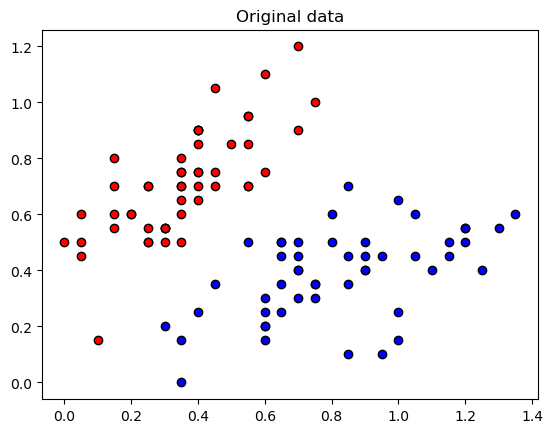

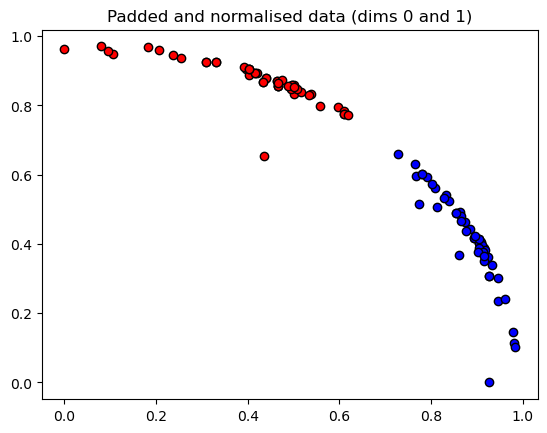

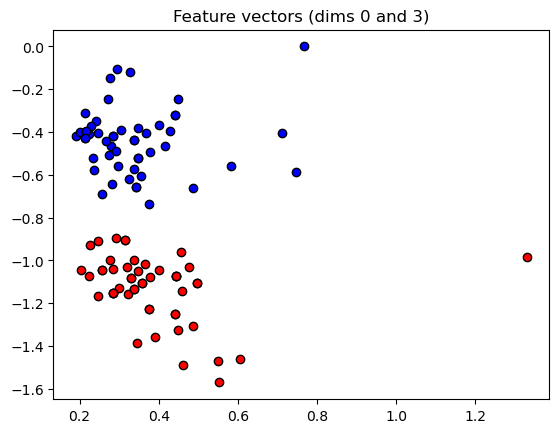

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

This time we want to generalize from the data samples. This means that
we want to train our model on one set of data and test its performance
on a second set of data that has not been used in training. To monitor
the generalization performance, the data is split into training and
validation set.


In [ ]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

# Optimization

First we initialize the variables.


In [ ]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)

Again we minimize the cost, using the imported optimizer.


In [ ]:
opt = MomentumQNGOptimizer(0.001)
#opt = qml.QNGOptimizer(0.01)

batch_size = 5

# train the variational classifier
weights = weights_init
for it in range(200):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    cost_fn = lambda w: cost(w, feats_train_batch, Y_train_batch)
    metric_fn = lambda w: np.sum([qml.metric_tensor(circuit, approx="block-diag")(w, sample) for sample in feats_train_batch], axis=0)/batch_size #we average the metric tensor over the batch

    weights, loss = opt.step_and_cost(cost_fn, weights, metric_tensor_fn=metric_fn)


    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, feats_val.T))
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.8170280 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.7118028 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.5725104 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     8 | Cost: 1.3431735 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    10 | Cost: 1.2131960 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    12 | Cost: 1.0315746 | Acc train: 0.4533333 | Acc validation: 0.5600000
Iter:    14 | Cost: 0.9570747 | Acc train: 0.6000000 | Acc validation: 0.6400000
Iter:    16 | Cost: 1.0860465 | Acc train: 0.5466667 | Acc validation: 0.4800000
Iter:    18 | Cost: 1.2278700 | Acc train: 0.5333333 | Acc validation: 0.4400000
Iter:    20 | Cost: 1.2371140 | Acc train: 0.5466667 | Acc validation: 0.4400000
Iter:    22 | Cost: 1.1433678 | Acc train: 0.5600000 | Acc validation: 0.4800000
Iter:    24 | Cost: 0.9780073 | Acc train: 0.5600000 | Acc validation: 0.4800000
Iter:    26 | Cost: 0.746804

We can plot the continuous output of the variational classifier for the
first two dimensions of the Iris data set.


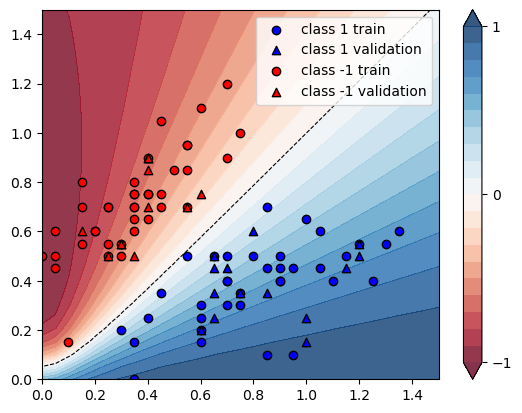

In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

We find that the variational classifier learnt a separating line between
the datapoints of the two different classes, which allows it to classify
even the unseen validation data with perfect accuracy.
